In [1]:
import stlearn as st
from pathlib import Path
import pandas as pd
from sklearn.metrics import adjusted_rand_score
from sklearn.preprocessing import LabelEncoder
import numpy as np
import scanpy

In [3]:
# specify PATH to data
BASE_PATH = Path("../data/human_DLPFC/")
MARKER_GENE_PATH = BASE_PATH / "marker_genes_summary.csv"
marker_gene_df = pd.read_csv(MARKER_GENE_PATH)
marker_gene = [i.upper() for i in marker_gene_df["symbol"].to_list()]

In [89]:
# here we include all 12 samples
sample_list = ["151507", "151508", "151509",
               "151510", "151669", "151670",
               "151671", "151672", "151673",
               "151674", "151675", "151676"]

In [94]:
df = pd.DataFrame(columns=['Sample', 'Adjusted_Rand_Score', 'PCA_or_UMAP', 'Method'])

In [95]:
for i in range(len(sample_list)):
    sample = sample_list[i]
    TILE_PATH = BASE_PATH / "{}_tiles".format(sample)
    TILE_PATH.mkdir(parents=True, exist_ok=True)
    
    GROUND_TRUTH_PATH = BASE_PATH / sample / "cluster_labels_{}.csv".format(sample)
    ground_truth_df = pd.read_csv(GROUND_TRUTH_PATH, sep=',', index_col=0)
    ground_truth_df.index = ground_truth_df.index.map(lambda x: x[7:])
    
    le = LabelEncoder()
    ground_truth_le = le.fit_transform(list(ground_truth_df["ground_truth"].values))
    ground_truth_df["ground_truth_le"] = ground_truth_le
    selected_columns = ground_truth_df.columns[1:-1]
    ground_truth_df_select = ground_truth_df[selected_columns]
    ari_ref = ground_truth_df_select.apply(lambda x : adjusted_rand_score(x, ground_truth_df["ground_truth_le"]), axis=0)
    ari_ref.head(50)
    
    for item in ari_ref.iteritems():
        method, ari_score = item
        pca_or_umap = "pca" if "PCA" in method else "umap"
        method = method.replace("_PCA", '')
        method = method.replace("_UMAP", '')
        df = df.append(pd.Series([sample, ari_score, pca_or_umap, method],
                       index=['Sample', 'Adjusted_Rand_Score', 'PCA_or_UMAP', 'Method']), ignore_index=True)

## Analysis

In [106]:
import statsmodels.api as sa
import statsmodels.formula.api as sfa
import scikit_posthocs as sp
import seaborn as sns, matplotlib.pyplot as plt

In [98]:
df["Method_Group"] = df["PCA_or_UMAP"] + "_" + df["Method"]

In [99]:
method_group = list(set(df["Method_Group"]))
method_group_values =[]
for i in method_group:
    method_group_values.append(list(df.loc[df["Method_Group"] == i, "Adjusted_Rand_Score"]))
method_group_values = np.array(method_group_values)

In [101]:
lm = sfa.ols('Adjusted_Rand_Score ~ C(Method_Group)', data=df).fit()

In [102]:
anova = sa.stats.anova_lm(lm)
anova

,df,sum_sq,mean_sq,F,PR(>F)
C(Method_Group),19.0,1.470179,0.077378,26.93096,5.191953e-47
Residual,220.0,0.632103,0.002873,NaN,NaN


# Violin plot

In [104]:
%matplotlib inline
plt.rcParams["legend.loc"] = 'upper left'
sns.set(style="whitegrid", palette="pastel", color_codes=True)
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.set_context("paper", font_scale=2)

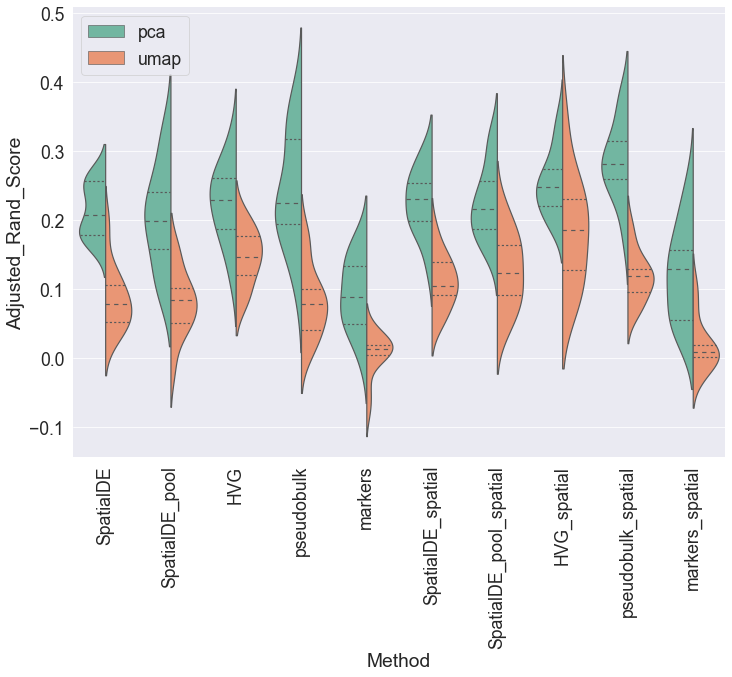

In [105]:
a = sns.violinplot(x="Method", y="Adjusted_Rand_Score", hue="PCA_or_UMAP",
               split=True, inner="quartile", scale="count",
               palette="Set2",
               data=df)
a.set_xticklabels(a.get_xticklabels(), rotation=90)
sns.despine(left=True)
a.legend(loc=2)
# plt.savefig(BASE_PATH / "Adjusted_Rand_Score.png", dpi=300)

In [125]:
df.to_csv('../data/violin_plot.csv', encoding='utf-8')

# pca & umap

In [ ]:
umap_df = df.loc[df["PCA_or_UMAP"]=="umap",:]
umap_posthoc = sp.posthoc_ttest(umap_df, val_col='Adjusted_Rand_Score', group_col='Method_Group', p_adjust='holm')

In [108]:
pca_df = df.loc[df["PCA_or_UMAP"]=="pca",:]
pca_posthoc = sp.posthoc_ttest(pca_df, val_col='Adjusted_Rand_Score', group_col='Method_Group', p_adjust='holm')

In [109]:
mask = np.zeros_like(pca_posthoc)
mask[np.triu_indices_from(mask)] = True

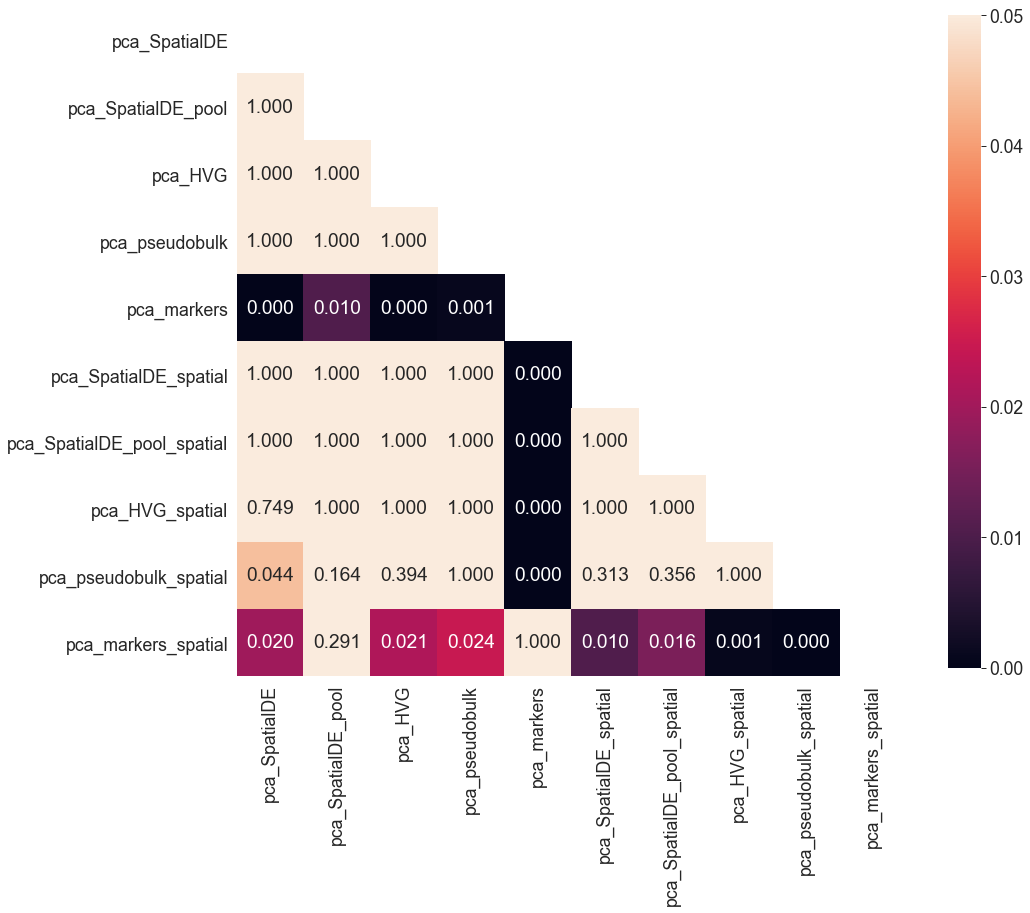

In [110]:
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(15, 15))
    ax = sns.heatmap(pca_posthoc, mask=mask, vmax=0.05, vmin=0, square=True, annot=True, fmt=".3f",
                     cbar_kws={"shrink": 0.8})

In [121]:
pca_posthoc.to_csv('../data/correlation_pca.csv', encoding='utf-8')
umap_posthoc.to_csv('../data/correlation_umap.csv', encoding='utf-8')